<a href="https://colab.research.google.com/github/MongiBESBES/Energy/blob/main/Analyse_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
data_to_load = files.upload()

Saving Dataset_Be.xlsx to Dataset_Be.xlsx


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [35]:
# Chargez les données depuis le fichier Excel
file_path = '/content/Dataset_Be.xlsx'
df = pd.read_excel(file_path)

# Supposons que la colonne contenant les dates s'appelle "date"
colonne_date = df["date"]

# Convertir la colonne "Date" en chaînes de caractères avec le format '%Y'
colonne_date_formattee = colonne_date.astype(str).str.zfill(4)

colonne_be = df["Be"]

In [36]:
df["Be"]

0       378.930215
1       378.830218
2       378.705471
3       378.577044
4       378.466012
           ...    
1031    380.732056
1032    368.017625
1033    353.363378
1034    339.171584
1035    327.844515
Name: Be, Length: 1036, dtype: float64

In [40]:


# Choisissez la colonne 'Be' comme variable cible
target_column = 'Be'
Be_values = df[target_column].values.reshape(-1, 1)

# Normalisez les valeurs entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
Be_scaled = scaler.fit_transform(Be_values)

# Créez la série temporelle avec des séquences d'entrée et de sortie
def create_time_series(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [42]:
Be_scaled

array([[0.33975518],
       [0.33919503],
       [0.33849622],
       ...,
       [0.19653618],
       [0.11703731],
       [0.05358592]])

In [43]:
# Définissez la taille de la fenêtre temporelle (look_back)
look_back = 30

# Créez la série temporelle
X, y = create_time_series(Be_scaled, look_back)

# Divisez les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshapez pour le format d'entrée GRU (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [44]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Construisez le modèle GRU
model = Sequential()
model.add(GRU(50, input_shape=(look_back, 1), kernel_initializer='glorot_uniform'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînez le modèle sur les données d'entraînement avec validation sur les données de validation
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

# Évaluez le modèle sur les données de test
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss on test set: {loss}')

# Effectuez des prédictions sur les données de test
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
26/26 - 3s - loss: 0.0777 - val_loss: 0.0303 - 3s/epoch - 114ms/step
Epoch 2/50
26/26 - 0s - loss: 0.0104 - val_loss: 0.0070 - 354ms/epoch - 14ms/step
Epoch 3/50
26/26 - 0s - loss: 0.0036 - val_loss: 0.0018 - 329ms/epoch - 13ms/step
Epoch 4/50
26/26 - 0s - loss: 0.0013 - val_loss: 0.0011 - 345ms/epoch - 13ms/step
Epoch 5/50
26/26 - 0s - loss: 9.4551e-04 - val_loss: 0.0010 - 365ms/epoch - 14ms/step
Epoch 6/50
26/26 - 0s - loss: 8.8980e-04 - val_loss: 0.0010 - 331ms/epoch - 13ms/step
Epoch 7/50
26/26 - 0s - loss: 8.0692e-04 - val_loss: 9.1007e-04 - 486ms/epoch - 19ms/step
Epoch 8/50
26/26 - 1s - loss: 7.2631e-04 - val_loss: 8.8059e-04 - 535ms/epoch - 21ms/step
Epoch 9/50
26/26 - 1s - loss: 7.0592e-04 - val_loss: 7.7617e-04 - 555ms/epoch - 21ms/step
Epoch 10/50
26/26 - 1s - loss: 6.4293e-04 - val_loss: 7.5265e-04 - 575ms/epoch - 22ms/step
Epoch 11/50
26/26 - 0s - loss: 5.8657e-04 - val_loss: 6.9232e-04 - 338ms/epoch - 13ms/step
Epoch 12/50
26/26 - 0s - loss: 5.3699e-04 - val_lo

In [51]:
# Récupérez les dates correspondant aux données de test
test_dates = df.index[-len(y_test):]+917

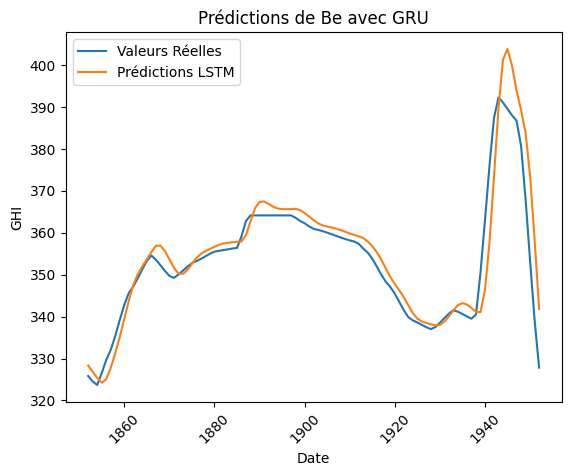

In [52]:
plt.plot(test_dates, y_test, label='True values')
plt.plot(test_dates, test_predict, label='GRU Predictions')
plt.title('Be Predictions with GRU')
plt.xlabel('Date')
plt.ylabel('Be')
plt.legend()
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.show()


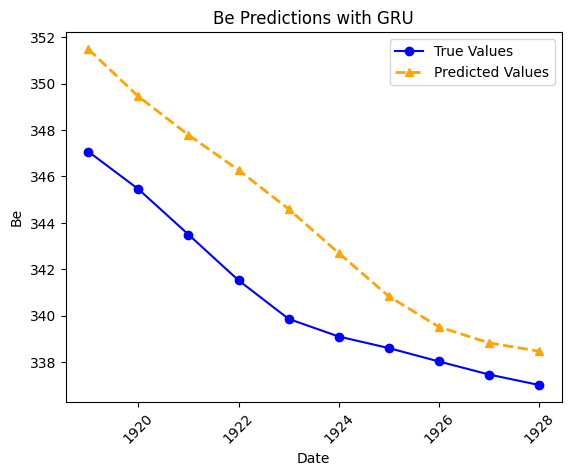

In [61]:
def plot_random_predictions(test_dates, y_test, test_predict):
    # Sélectionner une date aléatoire 35 jours avant la fin des dates de test
    random_date_index = len(test_dates) - 35
    random_date = test_dates[random_date_index]

    # Trouver l'index de la date aléatoire dans les dates de test
    random_date_index_test = np.where(test_dates == random_date)[0][0]

    # Extraire les 10 valeurs réelles qui suivent la date aléatoire
    y_test_values = y_test[random_date_index_test + 1:random_date_index_test + 11]

    # Extraire les valeurs prédites associées (en ajustant l'indice)
    test_predict_values = test_predict[random_date_index_test:random_date_index_test + 10]

    # Déballer la dimension supplémentaire dans test_predict_values
    test_predict_values = np.squeeze(test_predict_values, axis=-1)

    # Plot des résultats
    plt.plot(test_dates[random_date_index_test + 1:random_date_index_test + 11], y_test_values,
             label='True Values', color='blue', marker='o')
    plt.plot(test_dates[random_date_index_test + 1:random_date_index_test + 11], test_predict_values,
             label='Predicted Values', color='orange', linestyle='dashed', marker='^',linewidth=2)

    plt.title('Be Predictions with GRU')
    plt.xlabel('Date')
    plt.ylabel('Be')
    plt.legend()

    # Rotation des étiquettes de l'axe des x
    plt.xticks(rotation=45)

    plt.show()

# Utilisation de la fonction
plot_random_predictions(test_dates, y_test, test_predict)


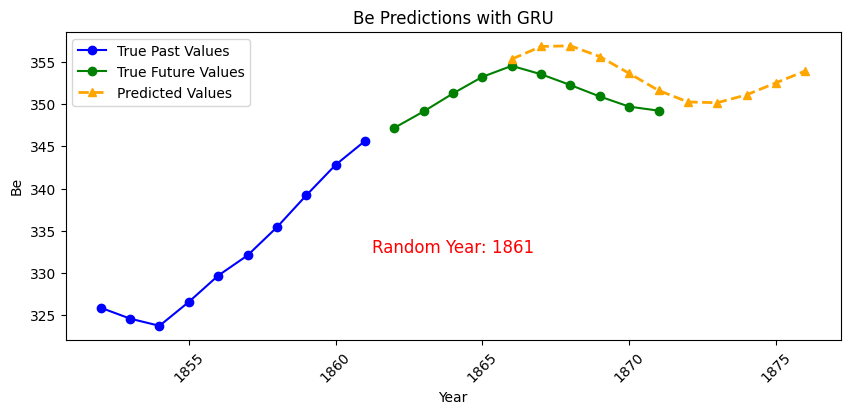

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_predictions(test_dates, y_test, test_predict, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Sélectionner une date aléatoire 35 jours avant la fin des dates de test
    random_date_index = np.random.choice(len(test_dates) - 35, size=1)[0]
    random_date = test_dates[random_date_index]

    # Trouver l'index de la date aléatoire dans les dates de test
    random_date_index_test = np.where(test_dates == random_date)[0][0]

    # Extraire les 10 valeurs réelles qui suivent la date aléatoire (True past values + True future values)
    true_past_values = y_test[random_date_index_test - 9:random_date_index_test + 1]
    true_future_values = y_test[random_date_index_test + 1:random_date_index_test + 11]

    # Extraire les 10 valeurs prédites associées (True future values + 5 valeurs prédites avant + 5 valeurs prédites après)
    test_predict_values = test_predict[random_date_index_test +5:random_date_index_test + 16]

    # Déballer la dimension supplémentaire dans test_predict_values
    test_predict_values = np.squeeze(test_predict_values, axis=-1)


    # Créer une nouvelle figure avec une taille personnalisée (par exemple, largeur=12, hauteur=6)
    plt.figure(figsize=(10, 4))


    # Plot des résultats
    plt.plot(test_dates[random_date_index_test - 9:random_date_index_test + 1], true_past_values,
             label='True Past Values', color='blue', marker='o')
    plt.plot(test_dates[random_date_index_test + 1:random_date_index_test + 11], true_future_values,
             label='True Future Values', color='green', marker='o')
    plt.plot(test_dates[random_date_index_test +5:random_date_index_test + 16], test_predict_values,
             label='Predicted Values', color='orange', linestyle='dashed', linewidth=2, marker='^')


    # Ajouter une annotation en bas de la figure
    plt.annotate(f'Random Year: {random_date}', xy=(0.5, 0.3), xytext=(0.5, 0.3), xycoords='axes fraction',
             textcoords='axes fraction', ha='center', va='center', fontsize=12, color='red',
             #arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='blue')
             )




    plt.title('Be Predictions with GRU')
    plt.xlabel('Year')
    plt.ylabel('Be')
    plt.legend()

    # Rotation des étiquettes de l'axe des x
    plt.xticks(rotation=45)

    plt.show()

# Utilisation de la fonction
plot_random_predictions(test_dates, y_test, test_predict)


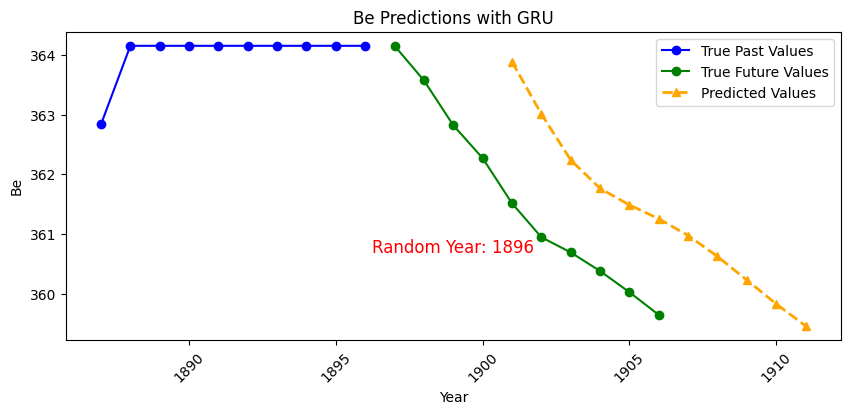

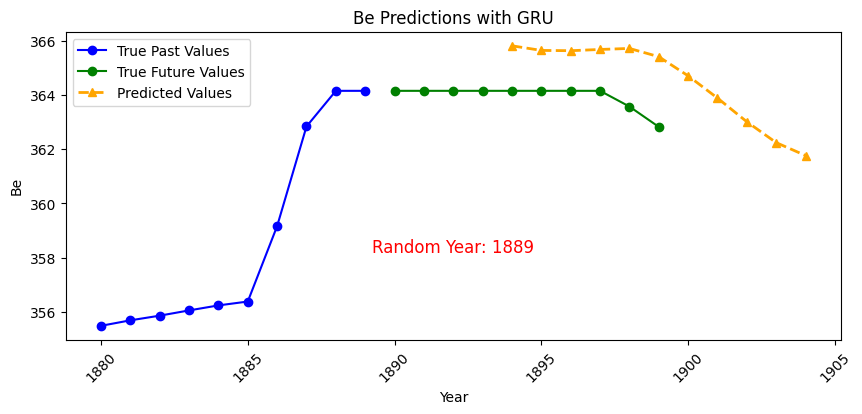

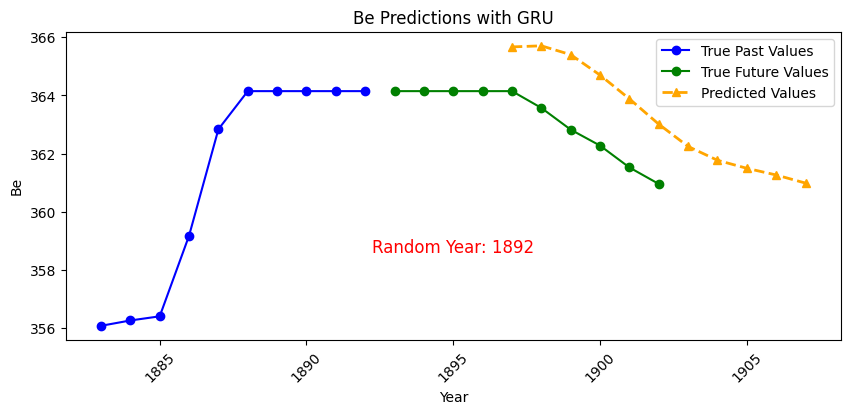

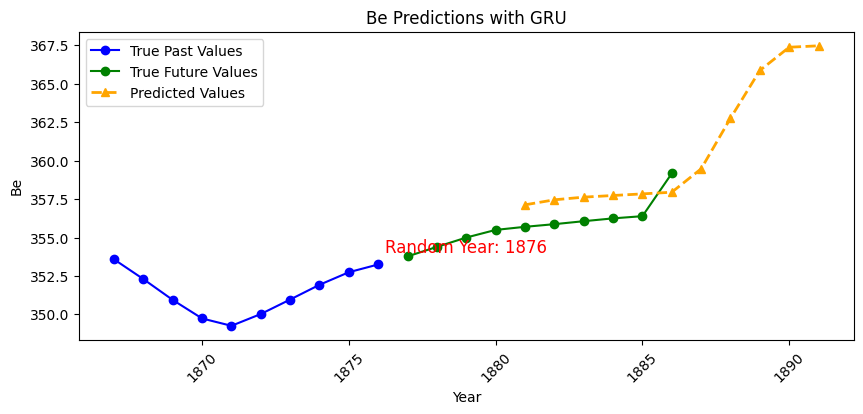

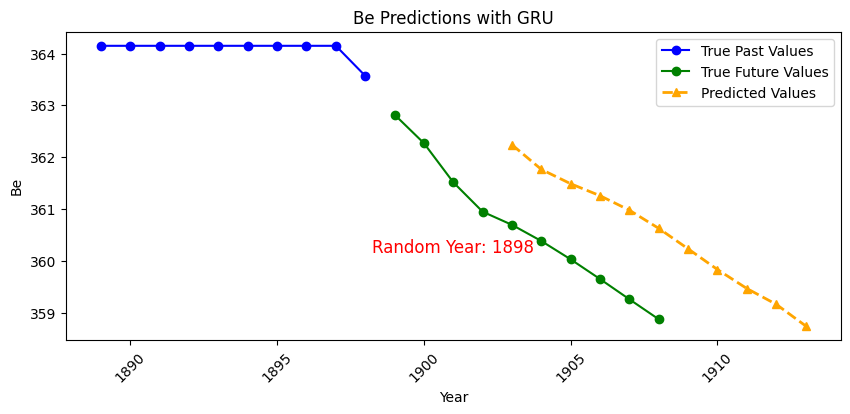

In [79]:
# Utilisation de la fonction plusieurs fois avec différentes dates aléatoires
for i in range(5):
    plot_random_predictions(test_dates, y_test, test_predict, random_seed=i)